In [136]:
import numpy as np

from skimage.transform import hough_line, hough_line_peaks, hough_circle, hough_circle_peaks
from skimage.draw import line, circle_perimeter, disk, ellipse_perimeter
from skimage import feature
from skimage.util import img_as_ubyte

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec

In [130]:
report_imgdir = "../../report/images/"

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## First image, points only

<ipython-input-149-51713cc336c7>:52: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


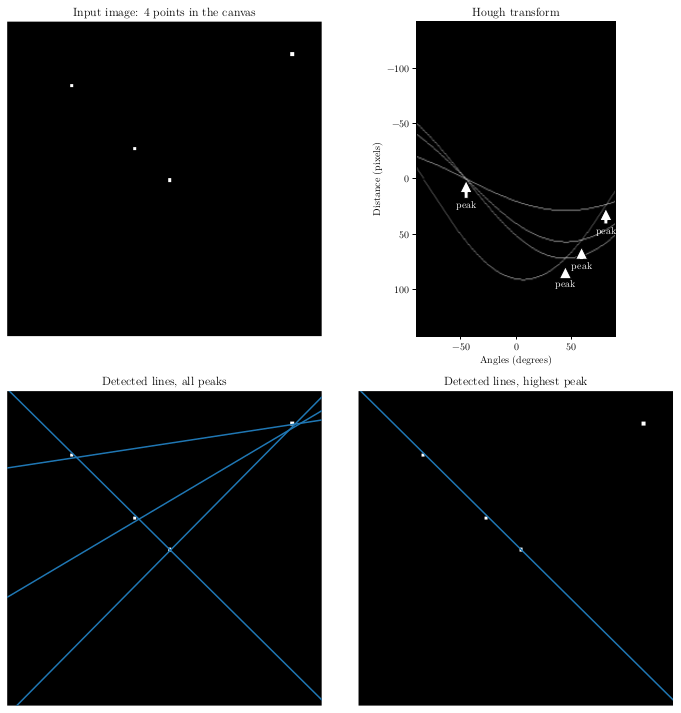

In [149]:
# Constructing input image
image = np.zeros((100, 100), dtype=np.bool)
image[20, 20] = True
image[40, 40] = True
image[50, 51] = True
image[10, 90] = True

# Hough transform
theta_angles = np.linspace(-np.pi/2, np.pi/2, num=270, endpoint=False)
h, theta, d = hough_line(image, theta=theta_angles)
# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title("Input image: 4 points in the canvas")
ax[0].set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [
    np.rad2deg(theta[0] - angle_step),
    np.rad2deg(theta[-1] + angle_step),
    d[-1] + d_step, d[0] - d_step
]
ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray) # np.log(1 + h) to increase brightness
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_title('Detected lines, all peaks')
ax[2].set_axis_off()
for h_peak, theta_peak, d_peak in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = d_peak * np.array([np.cos(theta_peak), np.sin(theta_peak)])
    ax[2].axline((x0, y0), slope=np.tan(theta_peak + np.pi/2))
    ax[1].annotate(
        "peak", xy=(np.rad2deg(theta_peak), d_peak*1.1),  xycoords='data',
        xytext=(np.rad2deg(theta_peak), d_peak+20), textcoords='data', color="white",
        arrowprops=dict(facecolor='white', shrink=0.05),
        horizontalalignment='center', verticalalignment='top',
    )

ax[3].imshow(image, cmap=cm.gray)
ax[3].set_title('Detected lines, highest peak')
ax[3].set_axis_off()
for h_peak, theta_peak, d_peak in zip(*hough_line_peaks(h, theta, d, threshold=0.8*np.amax(h))):
    (x0, y0) = d_peak * np.array([np.cos(theta_peak), np.sin(theta_peak)])
    ax[3].axline((x0, y0), slope=np.tan(theta_peak + np.pi/2))

fig.tight_layout()
plt.show()
plt.savefig(report_imgdir + "hough_demo_points.pgf")

## Second image, points and line

<ipython-input-132-658b8549b143>:48: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


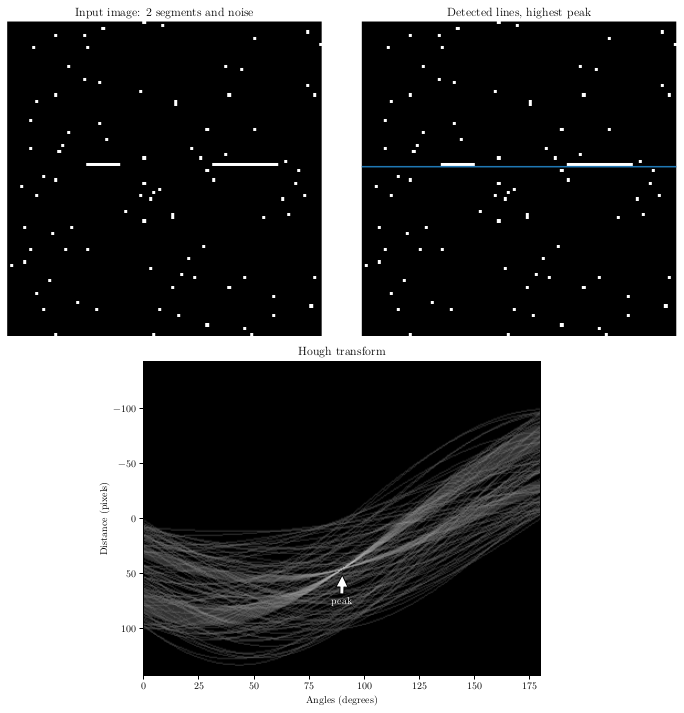

In [132]:
gs = gridspec.GridSpec(2, 2)

# Constructing input image
image = np.zeros((100, 100), dtype=np.bool)
image[line(45, 25, 45, 35)] = True
image[line(45, 65, 45, 85)] = True
image += np.random.random(image.shape) > 0.99
# Hough transform
theta_angles = np.linspace(0, np.pi, num=360, endpoint=False)
h, theta, d = hough_line(image, theta=theta_angles)

# Plot
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot(gs[0, 0]) 
ax1 = plt.subplot(gs[1, :])
ax2 = plt.subplot(gs[0, 1])

ax0.imshow(image, cmap=cm.gray)
ax0.set_title("Input image: 2 segments and noise")
ax0.set_axis_off()

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [
    np.rad2deg(theta[0] - angle_step),
    np.rad2deg(theta[-1] + angle_step),
    d[-1] + d_step, d[0] - d_step
]
ax1.imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=0.5) # np.log(1 + h) to increase brightness
ax1.set_title('Hough transform')
ax1.set_xlabel('Angles (degrees)')
ax1.set_ylabel('Distance (pixels)')

ax2.imshow(image, cmap=cm.gray)
ax2.set_title('Detected lines, highest peak')
ax2.set_axis_off()
for h_peak, theta_peak, d_peak in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = d_peak * np.array([np.cos(theta_peak), np.sin(theta_peak)])
    ax2.axline((x0, y0), slope=np.tan(theta_peak + np.pi/2))
    ax1.annotate(
        "peak", xy=(np.rad2deg(theta_peak), d_peak*1.1),  xycoords='data',
        xytext=(0.5, 0.25), textcoords='axes fraction', color="white",
        arrowprops=dict(facecolor='white', shrink=0.05),
        horizontalalignment='center', verticalalignment='top',
    )

fig.tight_layout()
plt.show()
plt.savefig(report_imgdir + "hough_demo_segments_noise.pgf")

## Hough transform applied to circle detection for known radius

<ipython-input-151-97c0f4abd833>:44: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


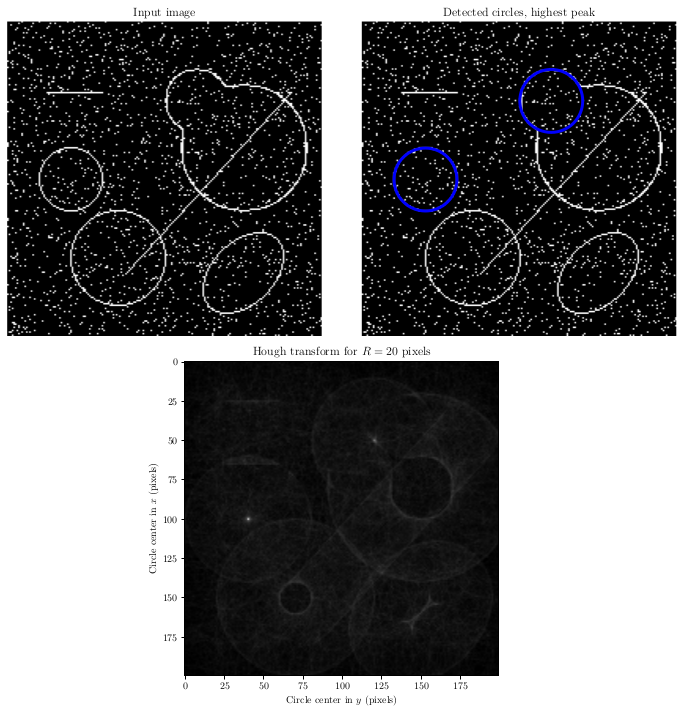

In [151]:
gs = gridspec.GridSpec(2, 2)

# Construct input image
image = np.zeros((200, 200), dtype=np.bool)
image[disk((50, 120), 20)] = True
image[disk((80, 150), 40)] = True
image = feature.canny(image, sigma=1)
image[line(45, 25, 45, 60)] = True
image[line(160, 75, 45, 180)] = True
image[circle_perimeter(100, 40, 20)] = True
image[circle_perimeter(150, 70, 30)] = True
image[ellipse_perimeter(160, 150, 20, 30, orientation=-np.pi/4.)] = True
image += np.random.random(image.shape) > 0.95

# Plot
fig = plt.figure(figsize=(10, 10))
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[1, :])
ax2 = plt.subplot(gs[0, 1])

ax0.imshow(image, cmap=cm.gray)
ax0.set_title("Input image")
ax0.set_axis_off()

hough_radii = np.arange(20, 21, 1)
hough_res = hough_circle(image, hough_radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=2)

hough_res = np.squeeze(hough_res)
ax1.imshow(hough_res, cmap=cm.gray)
ax1.set_title('Hough transform for $R=20$ pixels')
ax1.set_xlabel('Circle center in $y$ (pixels)')
ax1.set_ylabel('Circle center in $x$ (pixels)')

ax2.set_title('Detected circles, highest peak')
ax2.set_axis_off()
ax2.imshow(image, cmap=cm.gray)
for center_y, center_x, radius in zip(cy, cx, radii):
    circumf = plt.Circle((center_x, center_y), radius, color="b", fill=False, linewidth=3.0)
    ax2.add_patch(circumf)


fig.tight_layout()
plt.show()
plt.savefig(report_imgdir + "hough_demo_circles.pgf")

## Hough transform applied to circle detection for range of radii

<ipython-input-201-a1930fadb7c3>:43: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


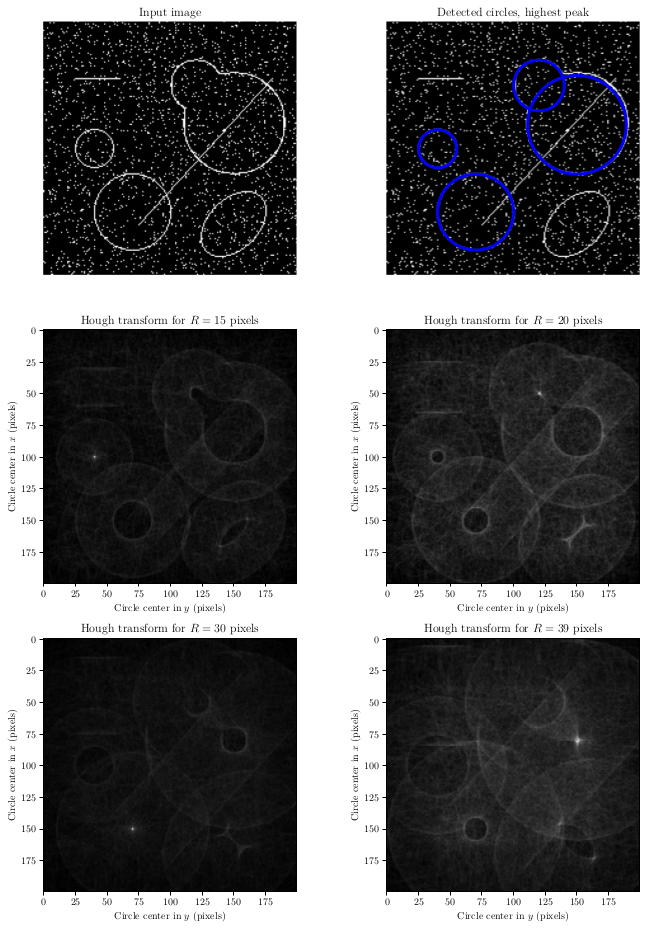

In [201]:
# Construct input image
image = np.zeros((200, 200), dtype=np.bool)
image[disk((50, 120), 20)] = True
image[disk((80, 150), 40)] = True
image = feature.canny(image, sigma=1)
image[line(45, 25, 45, 60)] = True
image[line(160, 75, 45, 180)] = True
image[circle_perimeter(100, 40, 15)] = True
image[circle_perimeter(150, 70, 30)] = True
image[ellipse_perimeter(160, 150, 20, 30, orientation=-np.pi/4.)] = True
image += np.random.random(image.shape) > 0.95

# Plot
fig, axs = plt.subplots(3, 2, figsize=(10, 13))

axs[0, 0].imshow(image, cmap=cm.gray)
axs[0, 0].set_title("Input image")
axs[0, 0].set_axis_off()

hough_radii = np.arange(15, 40, 1)
hough_res = hough_circle(image, hough_radii)
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=4)
found_radii_index = [idx for idx, val in enumerate(hough_radii) if val in radii]

ite = 0
for i in range(1, 3):
    for j in range(2):
        axs[i, j].imshow(hough_res[found_radii_index[ite],:,:], cmap=cm.gray)
        axs[i, j].set_title(f'Hough transform for $R={hough_radii[found_radii_index[ite]]}$ pixels')
        axs[i, j].set_xlabel('Circle center in $y$ (pixels)')
        axs[i, j].set_ylabel('Circle center in $x$ (pixels)')
        ite += 1

axs[0, 1].set_title('Detected circles, highest peak')
axs[0, 1].set_axis_off()
axs[0, 1].imshow(image, cmap=cm.gray)
for center_y, center_x, radius in zip(cy, cx, radii):
    circumf = plt.Circle((center_x, center_y), radius, color="b", fill=False, linewidth=3.0)
    axs[0, 1].add_patch(circumf)


fig.tight_layout()
plt.show()
plt.savefig(report_imgdir + "hough_demo_all_circles.pgf")